In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import scipy
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from glob import glob
import sys
import torch
from tqdm import tqdm
import pdb

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from dca_research.cov_util import calc_mmse_from_cross_cov_mats
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

In [4]:
sys.path.append('/home/akumar/nse/neural_control')

In [71]:
from loaders import load_sabes, load_peanut
from decoders import lr_decoder
from utils import apply_df_filters, calc_loadings
from consolidation import consolidate_decoding

In [ ]:
# Consolidate and plot decoding results

In [10]:
fls = glob('/mnt/Secondary/data/indy_decoding_cslacsl/indy_decoding*.dat')

In [15]:
consolidate_decoding('/mnt/Secondary/data/indy_decoding_cslacsl', '/mnt/Secondary/data/postprocessed/indy_cslacsl_decoding_df.dat')

In [22]:
with open('/mnt/Secondary/data/postprocessed/indy_cslacsl_decoding_df.dat', 'rb') as f:
    df = pickle.load(f)
df = pd.DataFrame(df)

In [25]:
# Filter by good loco files
fls_ = glob('/mnt/Secondary/data/sabes/*.mat')

good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

# Filter by the loco files we want to use
fls = []
for f in fls_:
    if 'indy' in f:
        fls.append(f.split('/')[-1])
    elif f.split('/')[-1] in good_loco_files:
        fls.append(f.split('/')[-1])

In [26]:
dfgood = apply_df_filters(df, data_file=fls)

In [30]:
dfgood.iloc[0]['dimreduc_args']

{'T': 3, 'loss_type': 'causal', 'n_init': 10}

In [34]:
dims = np.unique(dfgood['dim'].values)
r2fc2 = np.zeros((len(fls), dims.size, 5, 2))
for i, data_file in tqdm(enumerate(fls)):
    for j, dim in enumerate(dims):               
        for f in range(5):
            dim_fold_df = apply_df_filters(dfgood, data_file=data_file, dim=dim, fold_idx=f, dimreduc_method='LQGCA', dimreduc_args={'T': 3, 'loss_type': 'causal', 'n_init': 10})
            assert(dim_fold_df.shape[0] == 1)
            r2fc2[i, j, f, 0] = dim_fold_df.iloc[0]['r2'][1]

            dim_fold_df = apply_df_filters(dfgood, data_file=data_file, dim=dim, fold_idx=f, dimreduc_method='LQGCA', dimreduc_args={'T': 3, 'loss_type': 'acausal', 'n_init': 10})
            assert(dim_fold_df.shape[0] == 1)
            r2fc2[i, j, f, 1] = dim_fold_df.iloc[0]['r2'][1]

35it [00:14,  2.43it/s]


In [33]:
# Compare with ordinary PCA/LQGCA
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    rl = pickle.load(f)
indy_df = pd.DataFrame(rl)

# PCA results for indy should be taken from an older dataframe because indy_decoding_df2 
# erroneously did not restrict the PCA dimension prior to doing decoding
# Grab PCA results
with open('/mnt/Secondary/data/postprocessed/sabes_kca_decodign_df.dat', 'rb') as f:
    pca_decoding_df = pickle.load(f)

with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
    'loco_20170213_02.mat',
    'loco_20170215_02.mat',
    'loco_20170227_04.mat',
    'loco_20170228_02.mat',
    'loco_20170301_05.mat',
    'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)        

indy_data_files = np.unique(indy_df['data_file'].values)
loco_data_files = np.unique(loco_df['data_file'].values)

dims = np.unique(indy_df['dim'].values)
r2fc = np.zeros((len(indy_data_files) + len(loco_data_files), dims.size, 5))
sr2_vel_pca = np.zeros((len(indy_data_files) + len(loco_data_files), dims.size, 5))

for i, data_file in tqdm(enumerate(indy_data_files)):
    for j, dim in enumerate(dims):               
        for f in range(5):
            dim_fold_df = apply_df_filters(indy_df, data_file=data_file, dim=dim, fold_idx=f, dimreduc_method='LQGCA')
            assert(dim_fold_df.shape[0] == 1)
            r2fc[i, j, f] = dim_fold_df.iloc[0]['r2'][1]

            pca_df = apply_df_filters(pca_decoding_df, data_file=data_file, dim=dim, fold_idx=f, dr_method='PCA')
            assert(pca_df.shape[0] == 1)
            sr2_vel_pca[i, j, f] = pca_df.iloc[0]['r2'][1]

for i, data_file in tqdm(enumerate(loco_data_files)):
    for j, dim in enumerate(dims):               
        for f in range(5):
            dim_fold_df = apply_df_filters(loco_df, data_file=data_file, dim=dim, fold_idx=f, dimreduc_method='LQGCA')
            assert(dim_fold_df.shape[0] == 1)
            r2fc[i + len(indy_data_files), j, f] = dim_fold_df.iloc[0]['r2'][1]

            pca_df = apply_df_filters(loco_df, data_file=data_file, dim=dim, fold_idx=f, dimreduc_method='PCA')
            assert(pca_df.shape[0] == 1)
            sr2_vel_pca[i + len(indy_data_files), j, f] = pca_df.iloc[0]['r2'][1]


/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
28it [00:13,  2.13it/s]
7it [00:01,  4.56it/s]


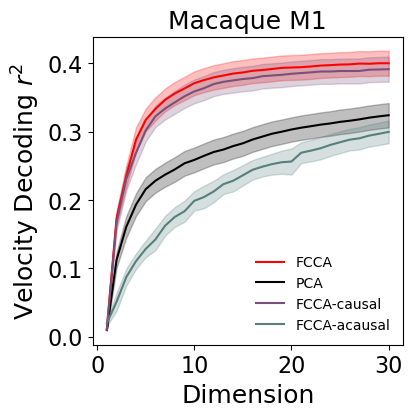

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Average across folds and plot
# REINSERT OLS(5) IN HERE IF NEEDED

colors = ['black', 'red', '#7a507a', '#55807c']
dim_vals = dims

# # DCA averaged over folds
# dca_r2 = np.mean(r2[:, :, 1, :, 1], axis=2)
# # KCA averaged over folds
# kca_r2 = np.mean(r2[:, :, 2, :, 1], axis=2)

# FCCA averaged over folds
fca_r2 = np.mean(r2fc[:, :, :], axis=2)
# PCA
pca_r2 = np.mean(sr2_vel_pca, axis=2)

# Causal/acausal FCCA
fca_r2c = np.mean(r2fc2[:, :, :, 0], axis=2)
fca_r2ac = np.mean(r2fc2[:, :, :, 1], axis=2)

# ax.fill_between(dim_vals, np.mean(dca_r2, axis=0) + np.std(dca_r2, axis=0)/np.sqrt(35),
#                 np.mean(dca_r2, axis=0) - np.std(dca_r2, axis=0)/np.sqrt(35), color=colors[0], alpha=0.25)
# ax.plot(dim_vals, np.mean(dca_r2, axis=0), color=colors[0])
# ax.fill_between(dim_vals, np.mean(kca_r2, axis=0) + np.std(kca_r2, axis=0)/np.sqrt(35),
#                 np.mean(kca_r2, axis=0) - np.std(kca_r2, axis=0)/np.sqrt(35), color=colors[1], alpha=0.25)
# ax.plot(dim_vals, np.mean(kca_r2, axis=0), color=colors[1])
ax.fill_between(dim_vals, np.mean(fca_r2, axis=0) + np.std(fca_r2, axis=0)/np.sqrt(35),
                np.mean(fca_r2, axis=0) - np.std(fca_r2, axis=0)/np.sqrt(35), color=colors[1], alpha=0.25)
ax.plot(dim_vals, np.mean(fca_r2, axis=0), color=colors[1])

ax.fill_between(dim_vals, np.mean(pca_r2, axis=0) + np.std(pca_r2, axis=0)/np.sqrt(35),
                np.mean(pca_r2, axis=0) - np.std(pca_r2, axis=0)/np.sqrt(35), color=colors[0], alpha=0.25)
ax.plot(dim_vals, np.mean(pca_r2, axis=0), color=colors[0])

ax.fill_between(dim_vals, np.mean(fca_r2c, axis=0) + np.std(fca_r2c, axis=0)/np.sqrt(35),
                np.mean(fca_r2c, axis=0) - np.std(fca_r2c, axis=0)/np.sqrt(35), color=colors[2], alpha=0.25)
ax.plot(dim_vals, np.mean(fca_r2c, axis=0), color=colors[2])

ax.fill_between(dim_vals, np.mean(fca_r2ac, axis=0) + np.std(fca_r2ac, axis=0)/np.sqrt(35),
                np.mean(fca_r2ac, axis=0) - np.std(fca_r2ac, axis=0)/np.sqrt(35), color=colors[3], alpha=0.25)
ax.plot(dim_vals, np.mean(fca_r2ac, axis=0), color=colors[3])



ax.set_xlabel('Dimension', fontsize=18)
ax.set_ylabel('Velocity Decoding ' + r'$r^2$', fontsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.legend(['FCCA', 'PCA', 'FCCA-causal', 'FCCA-acausal'], fontsize=10, loc='lower right', frameon=False)
#ax.legend(['FCCA', 'PCA'], fontsize=14, loc='lower right', frameon=False)

ax.set_title('Macaque M1', fontsize=18)
fig.savefig('/home/akumar/nse/neural_control/figs/cslacsl/m1_decoding.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Plot the pairwise decoding AUC between FCCA and KCA. This analysis also needs to be done for Peanut/CV

0.002824458380928263


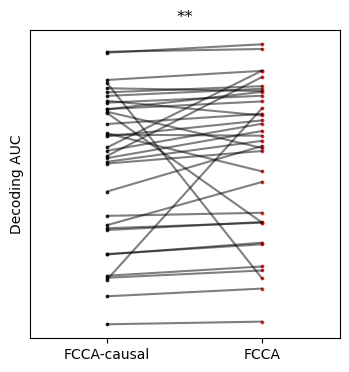

In [92]:
# Inset that shows the paired differences
fig, axin = plt.subplots(figsize=(4, 4))

fcac_auc = np.sum(fca_r2c, axis=1)
fca_auc = np.sum(fca_r2, axis=1)

# Run a signed rank test
_, p = scipy.stats.wilcoxon(fcac_auc, fca_auc, alternative='less')
print(p)

axin.scatter(np.zeros(35), fcac_auc, color='k', alpha=0.75, s=3)
axin.scatter(np.ones(35), fca_auc, color='r', alpha=0.75, s=3)
axin.plot(np.array([(0, 1) for _ in range(fca_r2c.shape[0])]).T, np.array([(y1, y2) for y1, y2 in zip(np.sum(fca_r2c, axis=1), np.sum(fca_r2, axis=1))]).T, color='k', alpha=0.5)
axin.set_yticks([])
axin.set_ylabel('Decoding AUC', fontsize=10)
axin.set_xlim([-0.5, 1.5])
axin.set_xticks([0, 1])
axin.set_xticklabels(['FCCA-causal', 'FCCA'], fontsize=10)
axin.set_title('**')
fig.savefig('/home/akumar/nse/neural_control/figs/cslacsl/m1_auc_diff.pdf', bbox_inches='tight', pad_inches=0)

In [67]:
consolidate_decoding('/mnt/Secondary/data/peanut_decoding_cslacsl', '/mnt/Secondary/data/postprocessed/peanut_cslacsl_decoding_df.dat')

In [73]:
with open('/mnt/Secondary/data/postprocessed/peanut_cslacsl_decoding_df.dat', 'rb') as f:
    d = pickle.load(f)
peanut_df2 = pd.DataFrame(d)

In [81]:
peanut_df2.iloc[0]['loader_args']

{'bin_width': 50,
 'epoch': 4,
 'filter_fn': 'none',
 'filter_kwargs': {},
 'boxcox': 0.5,
 'spike_threshold': 200,
 'speed_threshold': 4}

In [77]:
peanut_df2.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'decoder', 'decoder_args',
       'decoder_obj', 'r2', 'data_file', 'loader', 'loader_args', 'task_args',
       'data_path', 'results_file'],
      dtype='object')

In [94]:
with open('/mnt/Secondary/data/postprocessed/peanut_decoding_df.dat', 'rb') as f:
    peanut_decoding_df = pickle.load(f)

peanut_decoding_df = pd.DataFrame(peanut_decoding_df)
pdf_fca = apply_df_filters(peanut_decoding_df, dimreduc_method='LQGCA', dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':5})

#fig, ax = plt.subplots(4, 2, figsize=(10, 12))
epochs = np.unique(peanut_decoding_df['epoch'].values)
folds = np.unique(peanut_decoding_df['fold_idx'].values)
dimvals = np.unique(peanut_decoding_df['dim'].values)
decoder_args = [{'trainlag': 0, 'testlag': 0, 'decoding_window': 6}, {'trainlag': 3, 'testlag': 3, 'decoding_window': 6}, {'trainlag': 6, 'testlag': 6, 'decoding_window': 6}]

r2 = np.zeros((3, epochs.size, len(decoder_args), folds.size, dimvals.size))



for i, epoch in enumerate(epochs):
    for k, da in enumerate(decoder_args):
        for f, fold in enumerate(folds):
            for d, dimval in enumerate(dimvals):            
                df_ = apply_df_filters(pdf_fca, epoch=epoch, fold_idx=fold, dim=dimval, decoder_args=da)
                try:
                    assert(df_.shape[0] == 1)
                except:
                    pdb.set_trace()
                r2[0, i, k, f, d] = df_.iloc[0]['r2'][0]

                df_ = apply_df_filters(peanut_df2, loader_args={'bin_width': 50,
                                        'epoch': epoch,
                                        'filter_fn': 'none',
                                        'filter_kwargs': {},
                                        'boxcox': 0.5,
                                        'spike_threshold': 200,
                                        'speed_threshold': 4}, 
                                       fold_idx=fold, dim=dimval, dimreduc_args={'T': 3, 'loss_type': 'causal', 'n_init': 5})
                try:
                    assert(df_.shape[0] == 1)
                except:
                    pdb.set_trace()
                r2[1, i, k, f, d] = df_.iloc[0]['r2'][0]

                df_ = apply_df_filters(peanut_df2, loader_args={'bin_width': 50,
                                        'epoch': epoch,
                                        'filter_fn': 'none',
                                        'filter_kwargs': {},
                                        'boxcox': 0.5,
                                        'spike_threshold': 200,
                                        'speed_threshold': 4}, 
                                       fold_idx=fold, dim=dimval, dimreduc_args={'T': 3, 'loss_type': 'acausal', 'n_init': 5})
                try:
                    assert(df_.shape[0] == 1)
                except:
                    pdb.set_trace()
                r2[2, i, k, f, d] = df_.iloc[0]['r2'][0]

                

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [95]:
# Something went wrong with PCA results, just run them here real quick:
pca_r2 = np.zeros((epochs.size, len(decoder_args), 5, dimvals.size))
for i, epoch in tqdm(enumerate(epochs)):
    dat = load_peanut('/mnt/Secondary/data/peanut/data_dict_peanut_day14.obj', epoch=epoch, spike_threshold=200)
    X = dat['spike_rates']
    Y = dat['behavior']
    train_test = list(KFold(n_splits=5).split(X))
    for k, da in enumerate([decoder_args[0]]):
        for f, fold in enumerate(folds):
            for d, dimval in enumerate(dimvals):            

                df_ = apply_df_filters(peanut_decoding_df, epoch=epoch, dimreduc_method='PCA', fold_idx=fold, dim=dimval, decoder_args=da)
                try:
                    coef = df_.iloc[0]['coef'][:, 0:dimval]         
                except:
                    pdb.set_trace()

                train_idxs = train_test[f][0]
                test_idxs = train_test[f][1]

                Ytrain = Y[train_idxs]
                Ytest = Y[test_idxs]

                Xtrain = X[train_idxs] @ coef
                Xtest = X[test_idxs] @ coef


                try:
                    r2_pos, r2_vel, r2_acc, decoder_obj = lr_decoder(Xtest, Xtrain, Ytest, Ytrain, **da)
                except:
                    pdb.set_trace()
                pca_r2[i, k, f, d] = r2_pos


8it [01:24, 10.56s/it]


IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

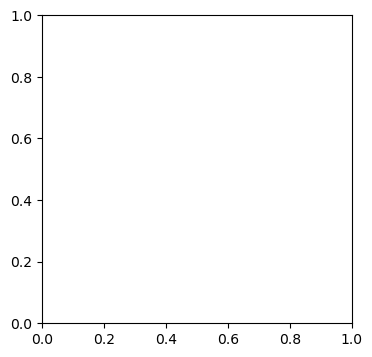

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Average over folds
fca_r2 = np.mean(r2[0, :, 0, :, :], axis=1)
pca_r2_ = np.mean(pca_r2[:, 0, :, :], axis=1)
fca_r2c = np.mean(r2[1, :, 0, :, :], axis=1)
fca_r2ac = np.mean(r2[2, :, 0, :, :], axis=1)

fca_mean = np.mean(fca_r2, axis=0)
fcac_mean = np.mean(fca_r2c, axis=0)
fcaac_mean = np.mean(fca_r2ac, axis=0)


# Move the fold indices up and then reshape to calc std
fca_std = np.std(fca_r2, axis=0)/np.sqrt(8)
fcac_std = np.std(fca_r2c, axis=0)/np.sqrt(8)
fcaac_std = np.std(fca_r2ac, axis=0)/np.sqrt(8)

pca_mean = np.mean(pca_r2_, axis=0)
pca_std = np.std(pca_r2_, axis=0)/np.sqrt(8)

ax.fill_between(np.arange(1, 31), fca_mean - fca_std, fca_mean + fca_std, color='r', alpha=0.25)
ax.fill_between(np.arange(1, 31), pca_mean - pca_std, pca_mean + pca_std, color='k', alpha=0.25)

ax.fill_between(np.arange(1, 31), fcac_mean - fcac_std, fcac_mean + fcac_std, color='#7a507a', alpha=0.25)
ax.fill_between(np.arange(1, 31), fcaac_mean - fcaac_std, fcaac_mean + fcaac_std, color='#55807c', alpha=0.25)


ax.plot(np.arange(1, 31), fca_mean, color='r')
ax.plot(np.arange(1, 31), pca_mean, color='k')
ax.plot(np.arange(1, 31), fcac_mean, color='#7a507a')
ax.plot(np.arange(1, 31), fcaac_mean, color='#55807c')


ax.legend(['FCCA', 'PCA', 'FCCA-causal', 'FCCA-acausal'])

0.00390625
0.07421875


[Text(0, 0, 'FCCA-acausal'), Text(1, 0, 'FCCA')]

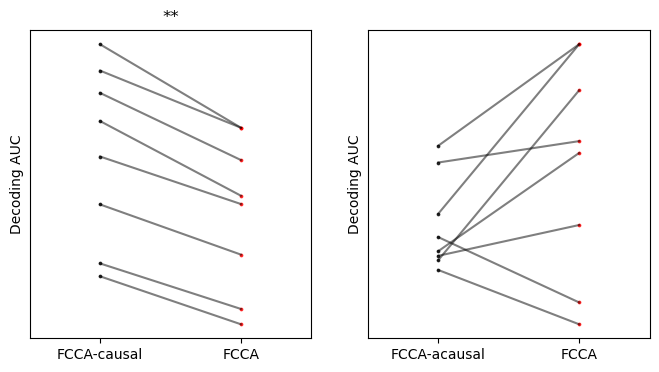

In [88]:
fig, axin = plt.subplots(1, 2, figsize=(8, 4))

kca_auc = np.sum(fca_r2c, axis=1)
fca_ac_auc = np.sum(fca_r2ac, axis=1)
fca_auc = np.sum(fca_r2, axis=1)

# Run a signed rank test
_, p = scipy.stats.wilcoxon(kca_auc, fca_auc, alternative='greater')
print(p)

_, p = scipy.stats.wilcoxon(fca_ac_auc, fca_auc, alternative='less')
print(p)


axin[0].scatter(np.zeros(8), kca_auc, color='k', alpha=0.75, s=3)
axin[0].scatter(np.ones(8), fca_auc, color='r', alpha=0.75, s=3)
axin[0].plot(np.array([(0, 1) for _ in range(fca_r2c.shape[0])]).T, np.array([(y1, y2) for y1, y2 in zip(np.sum(fca_r2c, axis=1), np.sum(fca_r2, axis=1))]).T, color='k', alpha=0.5)
axin[0].set_yticks([])
axin[0].set_ylabel('Decoding AUC', fontsize=10)
axin[0].set_xlim([-0.5, 1.5])
axin[0].set_xticks([0, 1])
axin[0].set_xticklabels(['FCCA-causal', 'FCCA'], fontsize=10)
axin[0].set_title('**')

axin[1].scatter(np.zeros(8), fca_ac_auc, color='k', alpha=0.75, s=3)
axin[1].scatter(np.ones(8), fca_auc, color='r', alpha=0.75, s=3)
axin[1].plot(np.array([(0, 1) for _ in range(fca_r2ac.shape[0])]).T, np.array([(y1, y2) for y1, y2 in zip(np.sum(fca_r2ac, axis=1), np.sum(fca_r2, axis=1))]).T, color='k', alpha=0.5)
axin[1].set_yticks([])
axin[1].set_ylabel('Decoding AUC', fontsize=10)
axin[1].set_xlim([-0.5, 1.5])
axin[1].set_xticks([0, 1])
axin[1].set_xticklabels(['FCCA-acausal', 'FCCA'], fontsize=10)
#axin[1].set_title('**')


In [47]:
# Then compare leverage scores between the 4 methods in the indy dataset and call it a day
# Assemble a loadings df. There are 6 pairwise comparisons to make.
DIM = 6

# Try the raw leverage scores instead
loadings_l = []
loadings_cslacsl = []
indy_data_files = np.unique(indy_df['data_file'].values)
for i, data_file in tqdm(enumerate(indy_data_files)):
    loadings = []
    loadings2 = []

    for dimreduc_method in ['LQGCA', 'PCA']:
        loadings_fold = []
        for fold_idx in range(5):  
            df_ = apply_df_filters(indy_df, data_file=data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method=dimreduc_method)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})
            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        
            loadings_fold.append(calc_loadings(V))
        # Average loadings across folds
        loadings.append(np.mean(np.array(loadings_fold), axis=0))


    for dimreduc_method in ['LQGCAc', 'LQGCAac']:
        loadings_fold = []
        for fold_idx in range(5):
            for fold_idx in range(5):  
                df_ = apply_df_filters(dfgood, data_file=data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method='LQGCA')
                if dimreduc_method == 'LQGCAc':
                    df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'causal', 'n_init': 10})
                if dimreduc_method == 'LQGCAac':
                    df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'acausal', 'n_init': 10})

                try:
                    assert(df_.shape[0] == 1)
                except:
                    pdb.set_trace()

                V = df_.iloc[0]['coef']
                loadings_fold.append(calc_loadings(V))
        # Average loadings across folds
        loadings2.append(np.mean(np.array(loadings_fold), axis=0))

    for j in range(loadings[0].size):
        d_ = {}
        d_['data_file'] = data_file
        d_['FCCA_loadings'] = loadings[0][j]
        d_['PCA_loadings'] = loadings[1][j]
        d_['FCCAc_loadings'] = loadings2[0][j]
        d_['FCCAac_loadings'] = loadings2[1][j]
        d_['nidx'] = j
        loadings_l.append(d_)                

loco_data_files = np.unique(loco_df['data_file'].values)
for i, data_file in tqdm(enumerate(loco_data_files)):
    loadings = []
    loadings2 = []

    for dimreduc_method in ['LQGCA', 'PCA']:
        loadings_fold = []
        for fold_idx in range(5):  
            df_ = apply_df_filters(loco_df, data_file=data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method=dimreduc_method)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})
            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        
            loadings_fold.append(calc_loadings(V))
        # Average loadings across folds
        loadings.append(np.mean(np.array(loadings_fold), axis=0))


    for dimreduc_method in ['LQGCAc', 'LQGCAac']:
        loadings_fold = []
        for fold_idx in range(5):
            for fold_idx in range(5):  
                df_ = apply_df_filters(dfgood, data_file=data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method='LQGCA')
                if dimreduc_method == 'LQGCAc':
                    df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'causal', 'n_init': 10})
                if dimreduc_method == 'LQGCAac':
                    df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'acausal', 'n_init': 10})

                assert(df_.shape[0] == 1)
                V = df_.iloc[0]['coef']
                loadings_fold.append(calc_loadings(V))
        # Average loadings across folds
        loadings2.append(np.mean(np.array(loadings_fold), axis=0))

    for j in range(loadings[0].size):
        d_ = {}
        d_['data_file'] = data_file
        d_['FCCA_loadings'] = loadings[0][j]
        d_['PCA_loadings'] = loadings[1][j]
        d_['FCCAc_loadings'] = loadings2[0][j]
        d_['FCCAac_loadings'] = loadings2[1][j]
        d_['nidx'] = j
        loadings_l.append(d_)                

loadings_df = pd.DataFrame(loadings_l)

28it [00:02, 10.87it/s]
7it [00:00, 12.71it/s]


In [55]:
import itertools

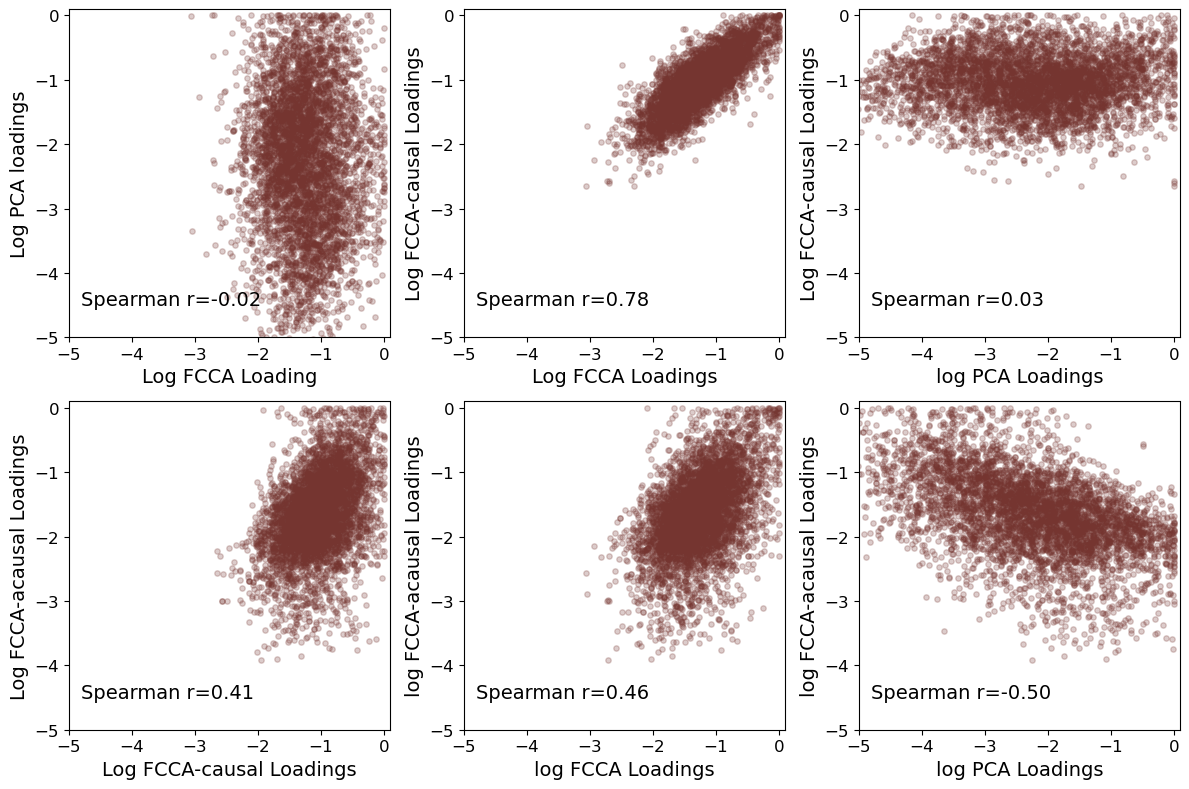

In [66]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

x1 = [loadings_df['FCCA_loadings'].values, loadings_df['FCCAc_loadings'].values, loadings_df['FCCA_loadings'].values, loadings_df['FCCA_loadings'].values, 
      loadings_df['PCA_loadings'].values, loadings_df['PCA_loadings'].values]
x2 = [loadings_df['PCA_loadings'].values, loadings_df['FCCAac_loadings'].values, loadings_df['FCCAc_loadings'].values, loadings_df['FCCAac_loadings'].values,
      loadings_df['FCCAc_loadings'].values, loadings_df['FCCAac_loadings'].values]

xlabels = ['Log FCCA Loading', 'Log FCCA-causal Loadings', 'Log FCCA Loadings', 'log FCCA Loadings', 'log PCA Loadings', 'log PCA Loadings']
ylabels = ['Log PCA loadings', 'Log FCCA-acausal Loadings', 'Log FCCA-causal Loadings', 'log FCCA-acausal Loadings', 'Log FCCA-causal Loadings', 'log FCCA-acausal Loadings']


for i in range(6):
    a = ax[np.unravel_index(i, (2, 3), order='F')]
    a.scatter(np.log10(x1[i]), np.log10(x2[i]), alpha=0.25, color='#753530', s=15)

    a.set_xlim([-5, 0.1])
    a.set_ylim([-5, 0.1])
    a.set_xlabel(xlabels[i], fontsize=14)
    a.set_ylabel(ylabels[i], fontsize=14)
    a.tick_params(axis='both', labelsize=12)

    # Annotate with the spearman-r
    r = scipy.stats.spearmanr(x1[i], x2[i])[0]
    a.annotate('Spearman r=%.2f' % r, (-4.8, -4.5), fontsize=14)
    fig.tight_layout()